In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mode
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split


In [3]:
train = pd.read_csv("../data/raw/train.csv")

In [4]:
train_labels = pd.read_csv("../data/raw/train_labels.csv")

In [5]:
test = pd.read_csv("../data/raw/test.csv")

In [167]:
train_labels.head()


,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


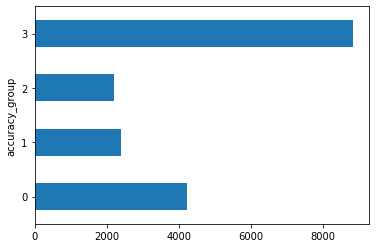

In [82]:
train_labels.groupby('accuracy_group')['game_session'].count().plot(kind='barh')
plt.show()

In [83]:
train_labels.groupby('accuracy_group')['installation_id'].count()

accuracy_group
0    4229
1    2411
2    2205
3    8845
Name: installation_id, dtype: int64

In [84]:
train_labels.groupby('accuracy_group')['game_session'].count()

accuracy_group
0    4229
1    2411
2    2205
3    8845
Name: game_session, dtype: int64

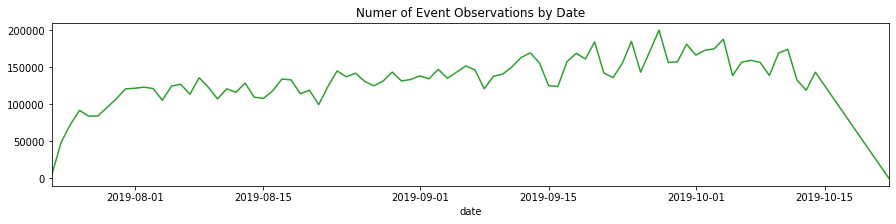

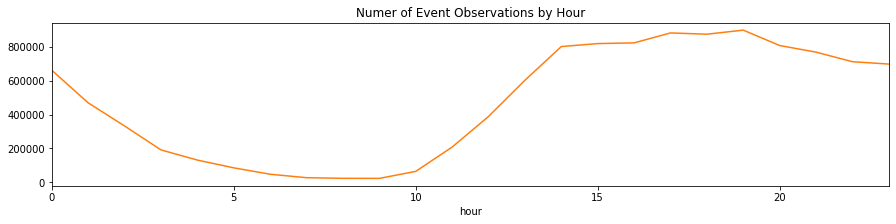

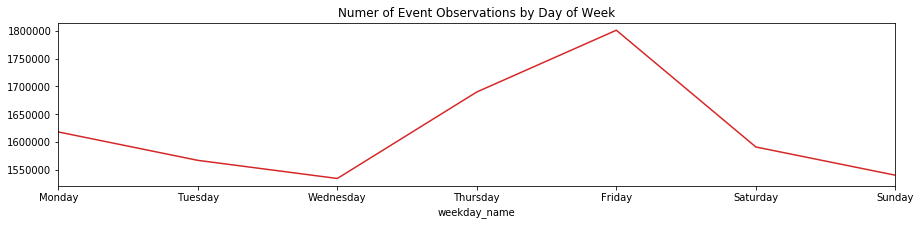

In [87]:
my_pal = sbs.color_palette(n_colors=10)
train.groupby('date')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Date',
         color=my_pal[2])
plt.show()
train.groupby('hour')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Hour',
         color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'].count().T[['Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday',
                     'Sunday']].T.plot(figsize=(15, 3),
                                       title='Numer of Event Observations by Day of Week',
                                       color=my_pal[3])
plt.show()

In [88]:
train.groupby('installation_id').count()['event_id']

installation_id
0001e90f    1357
000447c4     181
0006a69f    3801
0006c192    2224
0009a5a9     412
            ... 
fff64664     779
fff70c1e      44
fff744ce       3
fff944d5     173
fffc0583     251
Name: event_id, Length: 17000, dtype: int64

In [89]:
train.groupby('installation_id').count()

,event_id,game_session,timestamp,event_data,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
installation_id,,,,,,,,,,,,,
0001e90f,1357,1357,1357,1357,1357,1357,1357,1357,1357,1357,1357,1357,1357
000447c4,181,181,181,181,181,181,181,181,181,181,181,181,181
0006a69f,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801
0006c192,2224,2224,2224,2224,2224,2224,2224,2224,2224,2224,2224,2224,2224
0009a5a9,412,412,412,412,412,412,412,412,412,412,412,412,412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff64664,779,779,779,779,779,779,779,779,779,779,779,779,779
fff70c1e,44,44,44,44,44,44,44,44,44,44,44,44,44
fff744ce,3,3,3,3,3,3,3,3,3,3,3,3,3


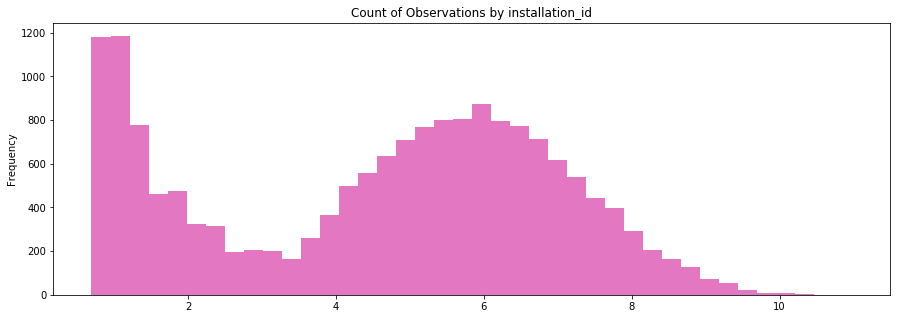

In [90]:
train.groupby('installation_id').count()['event_id'].apply(np.log1p).plot(kind='hist',
          bins=40,
          color=my_pal[6],
          figsize=(15, 5),
         title='Count of Observations by installation_id')
plt.show()

# Data Preprocessing

## Get rid of data not in labels

In [255]:
not_req=(set(train.installation_id.unique()) - set(train_labels.installation_id.unique()))

In [7]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    return df


In [8]:
time_features=['month','hour','year','dayofweek','weekofyear']
def  prepare_data(df):
    df=extract_time_features(df)
    df=df.drop('timestamp',axis=1)
    #df['timestamp']=pd.to_datetime(df['timestamp'])
    #df['hour_of_day']=df['timestamp'].map(lambda x : int(x.hour))
    
    #One hot encodes the events
    join_one=pd.get_dummies(df[['event_code','installation_id','game_session']],
                            columns=['event_code']).groupby(['installation_id','game_session'],
                                                            as_index=False,sort=False).agg(sum)

    #how many events an installation_id has done, how much game time total and avg, how many diff events total
    agg={'event_count':sum,'game_time':['sum','mean'],'event_id':'count'}
    join_two=df.drop(time_features,axis=1).groupby(['installation_id','game_session']
                                                   ,as_index=False,sort=False).agg(agg)
    #renaming col headings
    join_two.columns= [' '.join(col).strip() for col in join_two.columns.values]
    
    #Where the person started playing a game session
    join_three=df[['installation_id','game_session','type','world','title']].groupby(
                ['installation_id','game_session'],as_index=False,sort=False).first()
    
    #
    join_four=df[time_features+['installation_id','game_session']].groupby(['installation_id',
                'game_session'],as_index=False,sort=False).agg(mode)[time_features].applymap(lambda x: x.mode[0])
    
    join_one=join_one.join(join_four)
    
    join_five=(join_one.join(join_two.drop(['installation_id','game_session'],axis=1))). \
                         join(join_three.drop(['installation_id','game_session'],axis=1))
    
# use pd.concat to join the new columns with your original dataframe
#     join_five = join_five.join(pd.get_dummies(test_final[['title', 'type', 'world']]))
#     join_five.head()
# now drop the original 'country' column (you don't need it anymore)
   # join_five.drop(['title', 'type', 'world'],axis=1, inplace=True)

    return join_five

In [10]:
join_train=prepare_data(train)
cols=join_train.columns.to_list()[2:-3]
join_train[cols]=join_train[cols].astype('int16')

,installation_id,game_session,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,...,year,dayofweek,weekofyear,event_count sum,game_time sum,game_time mean,event_id count,type,world,title
0,0001e90f,45bb1e1b6b50c07b,1,0,0,0,0,0,0,0,...,2019,4,36,1,0,0,1,Clip,NONE,Welcome to Lost Lagoon!
1,0001e90f,17eeb7f223665f53,1,0,0,0,0,0,0,0,...,2019,4,36,1,0,0,1,Clip,MAGMAPEAK,Magma Peak - Level 1
2,0001e90f,0848ef14a8dc6892,1,0,0,0,0,0,0,0,...,2019,4,36,-29758,-32667,13623,267,Activity,MAGMAPEAK,Sandcastle Builder (Activity)
3,0001e90f,a1ec58f109218255,1,0,0,0,0,0,0,0,...,2019,4,36,4371,7242,-29520,93,Activity,MAGMAPEAK,Sandcastle Builder (Activity)
4,0001e90f,f11eb823348bfa23,1,0,57,0,57,0,15,15,...,2019,4,36,12767,24898,-22874,741,Game,MAGMAPEAK,Scrub-A-Dub


In [75]:
join_test=prepare_data(test)
cols=join_test.columns.to_list()[2:-3]
join_test[cols]=join_test[cols].astype('int16')
test_new = prepare_data(test)

In [79]:
join_test.head()

,installation_id,game_session,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,...,year,dayofweek,weekofyear,event_count sum,game_time sum,game_time mean,event_id count,type,world,title
0,00abaee7,0ea9ecc81a565215,1,0,0,0,0,0,0,0,...,2019,1,37,1,0,0,1,Clip,NONE,Welcome to Lost Lagoon!
1,00abaee7,c1ea43d8b8261d27,1,0,0,0,0,0,0,0,...,2019,1,37,1,0,0,1,Clip,MAGMAPEAK,Magma Peak - Level 1
2,00abaee7,7ed86c6b72e725e2,1,0,0,0,0,0,0,0,...,2019,1,37,1,0,0,1,Clip,MAGMAPEAK,Magma Peak - Level 2
3,00abaee7,7e516ace50e7fe67,1,0,0,0,0,0,0,0,...,2019,1,37,1,0,0,1,Clip,CRYSTALCAVES,Crystal Caves - Level 1
4,00abaee7,a022c3f60ba547e7,1,0,1,0,0,0,0,0,...,2019,1,37,12720,13459,1733,159,Game,CRYSTALCAVES,Chow Time


In [80]:
join_train.head()

,installation_id,game_session,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,...,year,dayofweek,weekofyear,event_count sum,game_time sum,game_time mean,event_id count,type,world,title
0,0001e90f,45bb1e1b6b50c07b,1,0,0,0,0,0,0,0,...,2019,4,36,1,0,0,1,Clip,NONE,Welcome to Lost Lagoon!
1,0001e90f,17eeb7f223665f53,1,0,0,0,0,0,0,0,...,2019,4,36,1,0,0,1,Clip,MAGMAPEAK,Magma Peak - Level 1
2,0001e90f,0848ef14a8dc6892,1,0,0,0,0,0,0,0,...,2019,4,36,-29758,-32667,13623,267,Activity,MAGMAPEAK,Sandcastle Builder (Activity)
3,0001e90f,a1ec58f109218255,1,0,0,0,0,0,0,0,...,2019,4,36,4371,7242,-29520,93,Activity,MAGMAPEAK,Sandcastle Builder (Activity)
4,0001e90f,f11eb823348bfa23,1,0,57,0,57,0,15,15,...,2019,4,36,12767,24898,-22874,741,Game,MAGMAPEAK,Scrub-A-Dub


In [29]:
cols=join_test.columns[2:-12].to_list()
cols.append('event_id count')
cols.append('installation_id')

In [81]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [119]:
final_train=pd.merge(train_labels,join_train,on=['installation_id','game_session', 'title'],
                                         how='left').drop(['game_session', 'num_correct', 'num_incorrect', 'accuracy'],axis=1)
final_train = final_train.join(pd.get_dummies(final_train[['title', 'type', 'world']]))
final_train.drop(['title', 'type', 'world'],axis=1, inplace=True) 

final_train.groupby('installation_id').count()
final_train.to_csv("../data/final_train_micha.csv")
# final_train = final_train.groupby('installation_id').count()
final_train.head()

final_test = join_test.join(pd.get_dummies(join_test[['title', 'type', 'world']]))
final_test.drop(['title', 'type', 'world'],axis=1, inplace=True) 


(17690, 65)

In [54]:
final_train.to_csv("../data/test_final.csv", sep="\t")

In [49]:
final_test

(95428453, 19)

In [120]:
train_labels.shape, final_test.shape, final_train.shape

((17690, 7), (28445, 105), (17690, 62))

# Examine data with labels

In [123]:
final_test

,installation_id,game_session,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,...,title_Watering Hole (Activity),title_Welcome to Lost Lagoon!,type_Activity,type_Assessment,type_Clip,type_Game,world_CRYSTALCAVES,world_MAGMAPEAK,world_NONE,world_TREETOPCITY
0,00abaee7,0ea9ecc81a565215,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,00abaee7,c1ea43d8b8261d27,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,00abaee7,7ed86c6b72e725e2,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,00abaee7,7e516ace50e7fe67,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,00abaee7,a022c3f60ba547e7,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28440,ffe774cc,f45f3ef5c0a3beee,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
28441,ffe774cc,30a00e218c275771,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
28442,ffe774cc,46ff9d3ad2be09f2,1,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
28443,ffe774cc,96d7dc31e822cedc,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


# Model

In [89]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [100]:
X, y = final_train[[x for x in final_train.columns if x not in ['accuracy_group', 'installation_id']]], final_train['accuracy_group']

In [101]:
fold = KFold(n_splits=10, shuffle=True, random_state=2019)

In [102]:
X.head()

,num_correct,num_incorrect,accuracy,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,...,event_id count,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment),type_Assessment,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY
0,1,0,1.0,1,1,1,1,1,1,0,...,35,0,0,0,0,1,1,0,0,1
1,0,11,0.0,1,0,1,0,0,0,0,...,87,1,0,0,0,0,1,0,0,1
2,1,0,1.0,1,1,1,1,1,1,0,...,48,0,0,0,0,1,1,0,0,1
3,1,1,0.5,1,1,1,1,1,1,0,...,42,0,0,0,0,1,1,0,0,1
4,1,0,1.0,1,1,2,0,2,0,0,...,32,1,0,0,0,0,1,0,0,1


In [103]:
fold_num = 1
accuracy = 0.0
accuracy_tree = 0.0
score = 0.0
for train, validation in fold.split(X,y):
   #print(validation)
    X_train = X.iloc[train]
    y_train = y[train]
    X_test = X.iloc[validation]
    y_test = y[validation]
    print("Fold # {}".format(fold_num))
    fold_num += 1
    rf = RandomForestClassifier(n_estimators = 10, random_state = 2019)
    dt = tree.DecisionTreeClassifier()
    dt_model = dt.fit(X_train, y_train)
    model = rf.fit(X_train, y_train)
    predictions_dt = dt_model.predict(X_test)
    predictions = model.predict(X_test)
    accuracy += metrics.accuracy_score(predictions, y_test)
    accuracy_tree += metrics.accuracy_score(predictions_dt, y_test)
    score+=metrics.cohen_kappa_score(predictions,y_test,weights='quadratic')
print(accuracy/fold_num)
print(accuracy_tree/fold_num)
print(score/fold_num)
dt_model
output_rf = pd.DataFrame({'installation_id':X_test.axes[0].tolist(), 'accuracy_group':predictions})
output_dt = pd.DataFrame({'installation_id':X_test.axes[0].tolist(), 'accuracy_group':predictions_dt})

output_rf.to_csv('../data/random_forest_predictions.csv')
output_dt.to_csv('../data/decision_tree_predictions.csv')


    
    

Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Fold # 6
Fold # 7
Fold # 8
Fold # 9
Fold # 10
0.9090395189886429
0.9090909090909091
0.9090245305623406


In [110]:
join_test.shape, X_train.shape

((28445, 56), (15921, 63))